### Consolidated importing, joining, and cleaning data as a function

In [1]:
# --- IMPORTS ---
import numpy as np
import pandas as pd
import sqlite3

def generatePeopleDataFrame(filepath_tn, filepath_imdb):
    # Suppresses SettingWithCopyWarning warnings
    pd.set_option('mode.chained_assignment', None)
    
    # --- FILEPATH IMPORTS ---
    # The Numbers movie information table
    tn_movies_df = pd.read_csv(filepath_tn)

    for column_title in ['production_budget', 'domestic_gross', 'worldwide_gross']:
        tn_movies_df[column_title].replace('[^\d]', '', inplace=True, regex=True)
        tn_movies_df[column_title] = tn_movies_df[column_title].astype(str).astype(np.int64)
    
    # IMDB database
    # ***IMPORTANT*** Make sure to unzip the "im.db.zip" file
    con = sqlite3.connect(filepath_imdb) 
    cursor = con.cursor()
    
    imdb_directors_df = pd.read_sql('''
    SELECT
        *
    FROM
        directors
    ''', con)

    imdb_writers_df = pd.read_sql('''
    SELECT
        *
    FROM
        writers
    ''', con)

    imdb_known_for_df = pd.read_sql('''
    SELECT
        *
    FROM
        known_for
    ''', con)

    imdb_persons_df = pd.read_sql('''
    SELECT
        *
    FROM
        persons
    ''', con)

    imdb_movie_basics_df = pd.read_sql('''
    SELECT
        *
    FROM
        movie_basics
    ''', con)

    # --- CREATING & CLEANING TEMP DATAFRAMES ---
    # - DIRECTORS DFS -
    dir_df = imdb_directors_df.merge(
        imdb_persons_df,
        how='left',
        on='person_id'
    ).merge(
        imdb_movie_basics_df,
        how='left',
        on='movie_id'
    ).merge(
        tn_movies_df,
        how='left',
        left_on='primary_title',
        right_on='movie'
    ).drop(columns=['birth_year', 'primary_profession', 'start_year', 'movie', 'runtime_minutes', 'id', 'release_date'])
    
    # Removing duplicates
    dir_df.drop_duplicates(inplace=True)

    # Remove any dead directors
    dir_df = dir_df[dir_df['death_year'].isna()]

    # Remove any movies that did not have a matching TN entry or have no revenue data
    dir_df.dropna(subset=['domestic_gross', 'worldwide_gross'], how='all', inplace=True)

    # Add a total_gross column and remove 0 revenue data (indicative of missing data)
    dir_df['total_gross'] = dir_df.domestic_gross + dir_df.worldwide_gross
    dir_df.drop(dir_df.loc[dir_df.total_gross == 0].index, inplace=True)
    
    # Remove any movies that did not have genre information, then convert genre column to list
    dir_df.dropna(subset=['genres'], inplace=True)
    dir_df['genres'] = dir_df.genres.apply(lambda x: x.lower().split(','))
    
    # Consolidate primary_title, domestic_gross, worldwide_gross, and total_gross into one dictionary in the movie_info column in a new DF
    grp_dir_df = dir_df.copy()
    grp_dir_df['movie_info'] = dir_df[['primary_title', 'genres', 'domestic_gross', 'worldwide_gross', 'total_gross', 'production_budget']].to_dict(orient='records')

    # Group by director
    grp_dir_df = grp_dir_df.movie_info.groupby(grp_dir_df.primary_name).apply(list).reset_index()

    # Add num_movies column, get rid of directors with < 3 movies
    grp_dir_df['num_movies'] = grp_dir_df.movie_info.str.len()
    grp_dir_df.drop(grp_dir_df[grp_dir_df['num_movies'] < 3].index, inplace=True)
    grp_dir_df.reset_index(inplace=True)
    
    # Uses ungrouped dataframe to find mean, median, and standard deviation of total gross revenue per director (also assigns genre information)
    grp_dir_df['genres'] = np.empty((len(grp_dir_df), 0)).tolist()
    grp_dir_df['mean_total_gross'] = np.nan
    grp_dir_df['median_total_gross'] = np.nan
    grp_dir_df['std_total_gross'] = np.nan

    for d in grp_dir_df.index:
        temp = dir_df.loc[dir_df.primary_name == grp_dir_df.primary_name[d]]
        grp_dir_df.mean_total_gross.iloc[d] = np.mean(temp.total_gross)
        grp_dir_df.median_total_gross.iloc[d] = np.median(temp.total_gross)
        grp_dir_df.std_total_gross.iloc[d] = np.std(temp.total_gross, ddof=1)
        for genre in temp.genres:
            grp_dir_df.genres[d].extend(genre)
    
    # Remove duplicate genres
    grp_dir_df.genres = grp_dir_df.genres.apply(set).apply(list)
    
    # 0 stddev = duplicate movies
    grp_dir_df.drop(grp_dir_df[grp_dir_df.std_total_gross == 0].index, inplace=True)

    # Calculates & creates coefficient of variation column
    grp_dir_df['coefficient_of_variation'] = grp_dir_df.std_total_gross / grp_dir_df.mean_total_gross
    grp_dir_df.sort_values('coefficient_of_variation', inplace=True)
    
    # Final cleaning & adding profession-identifying column
    grp_dir_df['profession'] = 'director'
    grp_dir_df.reset_index(inplace=True)
    grp_dir_df.drop(columns=['level_0', 'index'], inplace=True)
    
    # - WRITERS DFS -
    wri_df = imdb_writers_df.merge(
        imdb_persons_df,
        how='left',
        on='person_id'
    ).merge(
        imdb_movie_basics_df,
        how='left',
        on='movie_id'
    ).merge(
        tn_movies_df,
        how='left',
        left_on='primary_title',
        right_on='movie'
    ).drop(columns=['birth_year', 'primary_profession', 'start_year', 'movie', 'runtime_minutes', 'id', 'release_date'])
    
    # Removing duplicates
    wri_df.drop_duplicates(inplace=True)

    # Remove any dead writers
    wri_df = wri_df[wri_df['death_year'].isna()]

    # Remove any movies that did not have a matching TN entry or have no revenue data
    wri_df.dropna(subset=['domestic_gross', 'worldwide_gross'], how='all', inplace=True)

    # Add a total_gross column and remove 0 revenue data (indicative of missing data)
    wri_df['total_gross'] = wri_df.domestic_gross + wri_df.worldwide_gross
    wri_df.drop(wri_df.loc[wri_df.total_gross == 0].index, inplace=True)
    
    # Remove any movies that did not have genre information, then convert genre column to list
    wri_df.dropna(subset=['genres'], inplace=True)
    wri_df['genres'] = wri_df.genres.apply(lambda x: x.lower().split(','))
    
    # Consolidate primary_title, domestic_gross, worldwide_gross, and total_gross into one dictionary in the movie_info column in a new DF
    grp_wri_df = wri_df.copy()
    grp_wri_df['movie_info'] = wri_df[['primary_title', 'genres', 'domestic_gross', 'worldwide_gross', 'total_gross', 'production_budget']].to_dict(orient='records')

    # Group by writer
    grp_wri_df = grp_wri_df.movie_info.groupby(grp_wri_df.primary_name).apply(list).reset_index()

    # Add num_movies column, get rid of writers with < 3 movies
    grp_wri_df['num_movies'] = grp_wri_df.movie_info.str.len()
    grp_wri_df.drop(grp_wri_df[grp_wri_df['num_movies'] < 3].index, inplace=True)
    grp_wri_df.reset_index(inplace=True)
    
    # Uses ungrouped dataframe to find mean, median, and standard deviation of total gross revenue per writer (also assigns genre information)
    grp_wri_df['genres'] = np.empty((len(grp_wri_df), 0)).tolist()
    grp_wri_df['mean_total_gross'] = np.nan
    grp_wri_df['median_total_gross'] = np.nan
    grp_wri_df['std_total_gross'] = np.nan

    for w in grp_wri_df.index:
        temp = wri_df.loc[wri_df.primary_name == grp_wri_df.primary_name[w]]
        grp_wri_df.mean_total_gross.iloc[w] = np.mean(temp.total_gross)
        grp_wri_df.median_total_gross.iloc[w] = np.median(temp.total_gross)
        grp_wri_df.std_total_gross.iloc[w] = np.std(temp.total_gross, ddof=1)
        for genre in temp.genres:
            grp_wri_df.genres[w].extend(genre)
    
    # Remove duplicate genres
    grp_wri_df.genres = grp_wri_df.genres.apply(set).apply(list)
    
    # 0 stddev = duplicate movies
    grp_wri_df.drop(grp_wri_df[grp_wri_df.std_total_gross == 0].index, inplace=True)

    # Calculates & creates coefficient of variation column
    grp_wri_df['coefficient_of_variation'] = grp_wri_df.std_total_gross / grp_wri_df.mean_total_gross
    grp_wri_df.sort_values('coefficient_of_variation', inplace=True)
    
    # Final cleaning & adding profession-identifying column
    grp_wri_df['profession'] = 'writer'
    grp_wri_df.reset_index(inplace=True)
    grp_wri_df.drop(columns=['level_0', 'index'], inplace=True)
    
    # Resets SettingWithCopyWarning suppression
    pd.reset_option("mode.chained_assignment")
    
    # - ACTORS DFS -
    act_df = imdb_known_for_df.merge(
        imdb_persons_df,
        how='left',
        on='person_id'
    ).merge(
        imdb_movie_basics_df,
        how='left',
        on='movie_id'
    ).merge(
        tn_movies_df,
        how='left',
        left_on='primary_title',
        right_on='movie'
    ).drop(columns=['birth_year', 'start_year', 'movie', 'runtime_minutes', 'id', 'release_date'])
    
    # Removing duplicates & non-actors/actresses
    act_df.drop_duplicates(inplace=True)
    act_df.dropna(subset=['primary_profession'], inplace=True)
    act_df = act_df[act_df.primary_profession.str.contains('actor|actress', case=False)]

    # Remove any dead actors/actresses
    act_df = act_df[act_df['death_year'].isna()]

    # Remove any movies that did not have a matching TN entry or have no revenue data
    act_df.dropna(subset=['domestic_gross', 'worldwide_gross'], how='all', inplace=True)

    # Add a total_gross column and remove 0 revenue data (indicative of missing data)
    act_df['total_gross'] = act_df.domestic_gross + act_df.worldwide_gross
    act_df.drop(act_df.loc[act_df.total_gross == 0].index, inplace=True)
    
    # Remove any movies that did not have genre information, then convert genre column to list
    act_df.dropna(subset=['genres'], inplace=True)
    act_df['genres'] = act_df.genres.apply(lambda x: x.lower().split(','))
    
    # Consolidate primary_title, domestic_gross, worldwide_gross, and total_gross into one dictionary in the movie_info column in a new DF
    grp_act_df = act_df.copy()
    grp_act_df['movie_info'] = act_df[['primary_title', 'genres', 'domestic_gross', 'worldwide_gross', 'total_gross', 'production_budget']].to_dict(orient='records')

    # Group by writer
    grp_act_df = grp_act_df.movie_info.groupby(grp_act_df.primary_name).apply(list).reset_index()

    # Add num_movies column, get rid of writers with < 3 movies
    grp_act_df['num_movies'] = grp_act_df.movie_info.str.len()
    grp_act_df.drop(grp_act_df[grp_act_df['num_movies'] < 3].index, inplace=True)
    grp_act_df.reset_index(inplace=True)
    
    # Uses ungrouped dataframe to find mean, median, and standard deviation of total gross revenue per writer (also assigns genre information)
    grp_act_df['genres'] = np.empty((len(grp_act_df), 0)).tolist()
    grp_act_df['mean_total_gross'] = np.nan
    grp_act_df['median_total_gross'] = np.nan
    grp_act_df['std_total_gross'] = np.nan
    
    # This particular loop sometimes takes a while to iterate through all the actors
    for a in grp_act_df.index: 
        temp = act_df.loc[act_df.primary_name == grp_act_df.primary_name[a]]
        grp_act_df.mean_total_gross.iloc[a] = np.mean(temp.total_gross)
        grp_act_df.median_total_gross.iloc[a] = np.median(temp.total_gross)
        grp_act_df.std_total_gross.iloc[a] = np.std(temp.total_gross, ddof=1)
        for genre in temp.genres:
            grp_act_df.genres[a].extend(genre)
    
    # Remove duplicate genres
    grp_act_df.genres = grp_act_df.genres.apply(set).apply(list)
    
    # 0 stddev = duplicate movies
    grp_act_df.drop(grp_act_df[grp_act_df.std_total_gross == 0].index, inplace=True)

    # Calculates & creates coefficient of variation column
    grp_act_df['coefficient_of_variation'] = grp_act_df.std_total_gross / grp_act_df.mean_total_gross
    grp_act_df.sort_values('coefficient_of_variation', inplace=True)
    
    # Final cleaning & adding profession-identifying column
    grp_act_df['profession'] = 'actor'
    grp_act_df.reset_index(inplace=True)
    grp_act_df.drop(columns=['level_0', 'index'], inplace=True)
    
    # Resets SettingWithCopyWarning suppression
    pd.reset_option("mode.chained_assignment")
    
    # --- CONCATENATION OF PERTINENT CLEANED DFS ---
    final_df = pd.concat([grp_dir_df, grp_wri_df, grp_act_df], keys=['directors', 'writers', 'actors'])
    
    return final_df

### Example usage of the above function

In [2]:
# This process can take a few minutes
people_risk_df = generatePeopleDataFrame('../data/tn.movie_budgets.csv.gz', '../data/im.db')
people_risk_df

C:\Users\nicho\.conda\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


primary_name  \
directors 0               Peter Jackson   
          1                Dean DeBlois   
          2     Rawson Marshall Thurber   
          3              James DeMonaco   
          4          Genndy Tartakovsky   
...                                 ...   
actors    1770           Parisse Boothe   
          1771          Timothy Johnson   
          1772           Jason Cavalier   
          1773               Scott Haze   
          1774                Pat Healy   

                                                       movie_info  num_movies  \
directors 0     [{'primary_title': 'The Hobbit: The Battle of ...           3   
          1     [{'primary_title': 'How to Train Your Dragon: ...           3   
          2     [{'primary_title': 'We're the Millers', 'genre...           3   
          3     [{'primary_title': 'The Purge', 'genres': ['ho...           3   
          4     [{'primary_title': 'Hotel Transylvania', 'genr...           3   
...                                                           ...         ...   
actors    1770  [{'primary_title': 'MacGruber', 'genres': ['ac...           4   
          1771  [{'primary_title': 'Carol', 'genres': ['drama'...           4   
          1772  [{'primary_title': 'Deadfall', 'genres': ['cri...           4   
          1773  [{'primary_title': 'Venom', 'genres': ['action...           4   
          1774  [{'primary_title': 'Compliance', 'genres': ['b...           4   

                                                           genres  \
directors 0                          [adventure, fantasy, family]   
          1                        [adventure, animation, action]   
          2          [comedy, adventure, crime, thriller, action]   
          3                    [sci-fi, thriller, horror, action]   
          4                [adventure, animation, comedy, family]   
...                                                           ...   
actors    1770  [comedy, adventure, crime, thriller, action, s...   
          1771  [adventure, drama, thriller, action, sci-fi, h...   
          1772  [adventure, crime, drama, thriller, action, sc...   
          1773  [mystery, biography, drama, thriller, action, ...   
          1774  [mystery, history, comedy, biography, crime, d...   

                mean_total_gross  median_total_gross  std_total_gross  \
directors 0         1.246479e+09        1.218734e+09     6.431229e+07   
          1         7.280305e+08        7.124522e+08     5.737818e+07   
          2         3.784606e+08        3.725357e+08     3.714348e+07   
          3         1.787981e+08        1.830974e+08     2.123767e+07   
          4         6.201998e+08        6.392004e+08     8.547937e+07   
...                          ...                 ...              ...   
actors    1770      5.711876e+08        6.318974e+07     1.046935e+09   
          1771      5.688606e+08        6.376292e+07     1.048603e+09   
          1772      2.564239e+08        2.108569e+07     4.837437e+08   
          1773      2.749402e+08        1.542862e+07     5.281828e+08   
          1774      6.600278e+07        1.119958e+06     1.304339e+08   

                coefficient_of_variation profession  
directors 0                     0.051595   director  
          1                     0.078813   director  
          2                     0.098144   director  
          3                     0.118780   director  
          4                     0.137826   director  
...                                  ...        ...  
actors    1770                  1.832909      actor  
          1771                  1.843339      actor  
          1772                  1.886500      actor  
          1773                  1.921083      actor  
          1774                  1.976188      actor  

[2271 rows x 9 columns]

In [3]:
people_risk_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2271 entries, ('directors', 0) to ('actors', 1774)
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   primary_name              2271 non-null   object 
 1   movie_info                2271 non-null   object 
 2   num_movies                2271 non-null   int64  
 3   genres                    2271 non-null   object 
 4   mean_total_gross          2271 non-null   float64
 5   median_total_gross        2271 non-null   float64
 6   std_total_gross           2271 non-null   float64
 7   coefficient_of_variation  2271 non-null   float64
 8   profession                2271 non-null   object 
dtypes: float64(4), int64(1), object(4)
memory usage: 260.3+ KB


In [4]:
# This DataFrame uses hierarchical indexing, as can be seen below
people_risk_df.loc['writers'].iloc[5]

primary_name                                                   James DeMonaco
movie_info                  [{'primary_title': 'The Purge', 'genres': ['ho...
num_movies                                                                  4
genres                                     [sci-fi, thriller, horror, action]
mean_total_gross                                                  1.85625e+08
median_total_gross                                                1.90327e+08
std_total_gross                                                   2.20709e+07
coefficient_of_variation                                               0.1189
profession                                                             writer
Name: 5, dtype: object

In [5]:
people_risk_df.loc['actors'].iloc[9].movie_info

[{'primary_title': 'Big Hero 6',
  'genres': ['action', 'adventure', 'animation'],
  'domestic_gross': 222527828.0,
  'worldwide_gross': 652127828.0,
  'total_gross': 874655656.0,
  'production_budget': 165000000.0},
 {'primary_title': 'Tangled',
  'genres': ['adventure', 'animation', 'comedy'],
  'domestic_gross': 200821936.0,
  'worldwide_gross': 586477240.0,
  'total_gross': 787299176.0,
  'production_budget': 260000000.0},
 {'primary_title': 'Moana',
  'genres': ['adventure', 'animation', 'comedy'],
  'domestic_gross': 248757044.0,
  'worldwide_gross': 637517365.0,
  'total_gross': 886274409.0,
  'production_budget': 150000000.0}]

<AxesSubplot:>

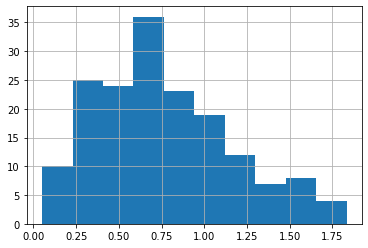

In [6]:
people_risk_df.loc['directors'].coefficient_of_variation.hist()